# Hydra Neuomechanical Modeling

In [155]:
%load_ext autoreload
%autoreload 2

import sys, os, multiprocessing
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
import h5py

from hydramuscle.model.smc import SMC
from hydramuscle.model.force_encoder_ecto import ForceEncoderEcto
from hydramuscle.model.force_encoder_endo import ForceEncoderEndo
from hydramuscle.model.fluo_encoder import FluoEncoder
from hydramuscle.model import plot
import hydramuscle.model.helper as helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Single-Cell Dynamics

In [2]:
# Define single-cell model
model = SMC(T=500, 
            dt=0.0002, 
            k_ipr=0.02, 
            s0=100, 
            d=20e-4, 
            v_delta=0.03)

100%|██████████| 10000/10000 [00:00<00:00, 20739.26it/s]


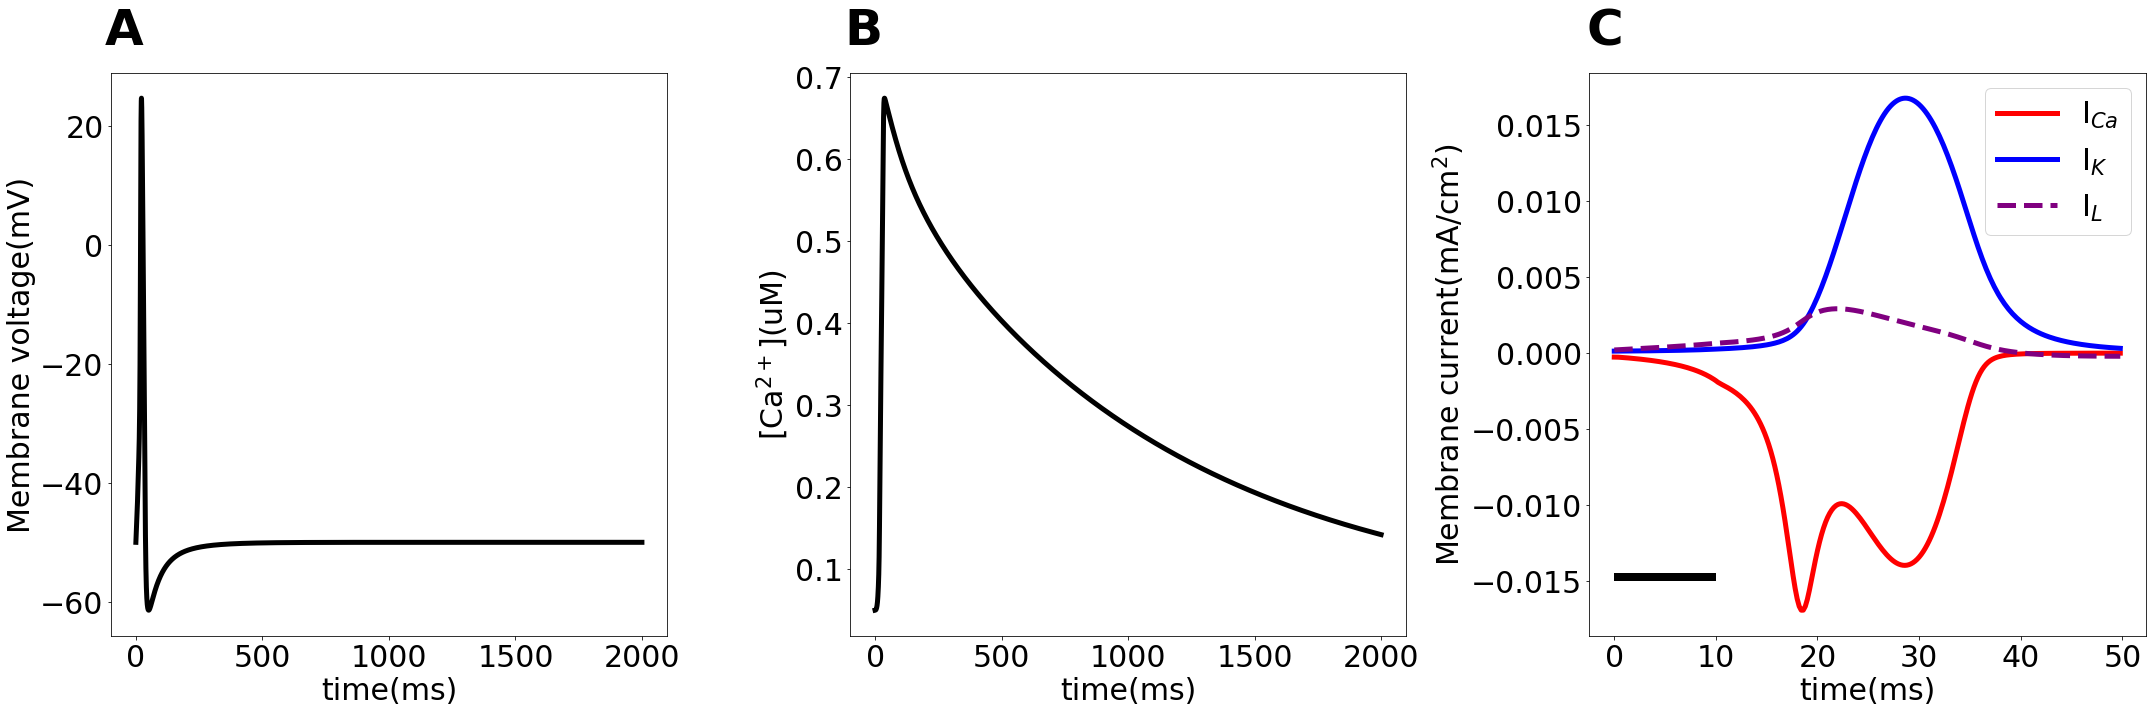

In [3]:
# Plot results of one fast spike
sol = model.run(stims_fast = [0], 
                stims_slow = [-100],
                T=2,
                dt=0.0002)
plot.plot_single_spike(model, sol, 0, 2, 0, 0.05, full_cell=True, save_fig=True, save_path="./results/figures/fast-pathway.png")

100%|██████████| 500000/500000 [00:23<00:00, 21084.55it/s]


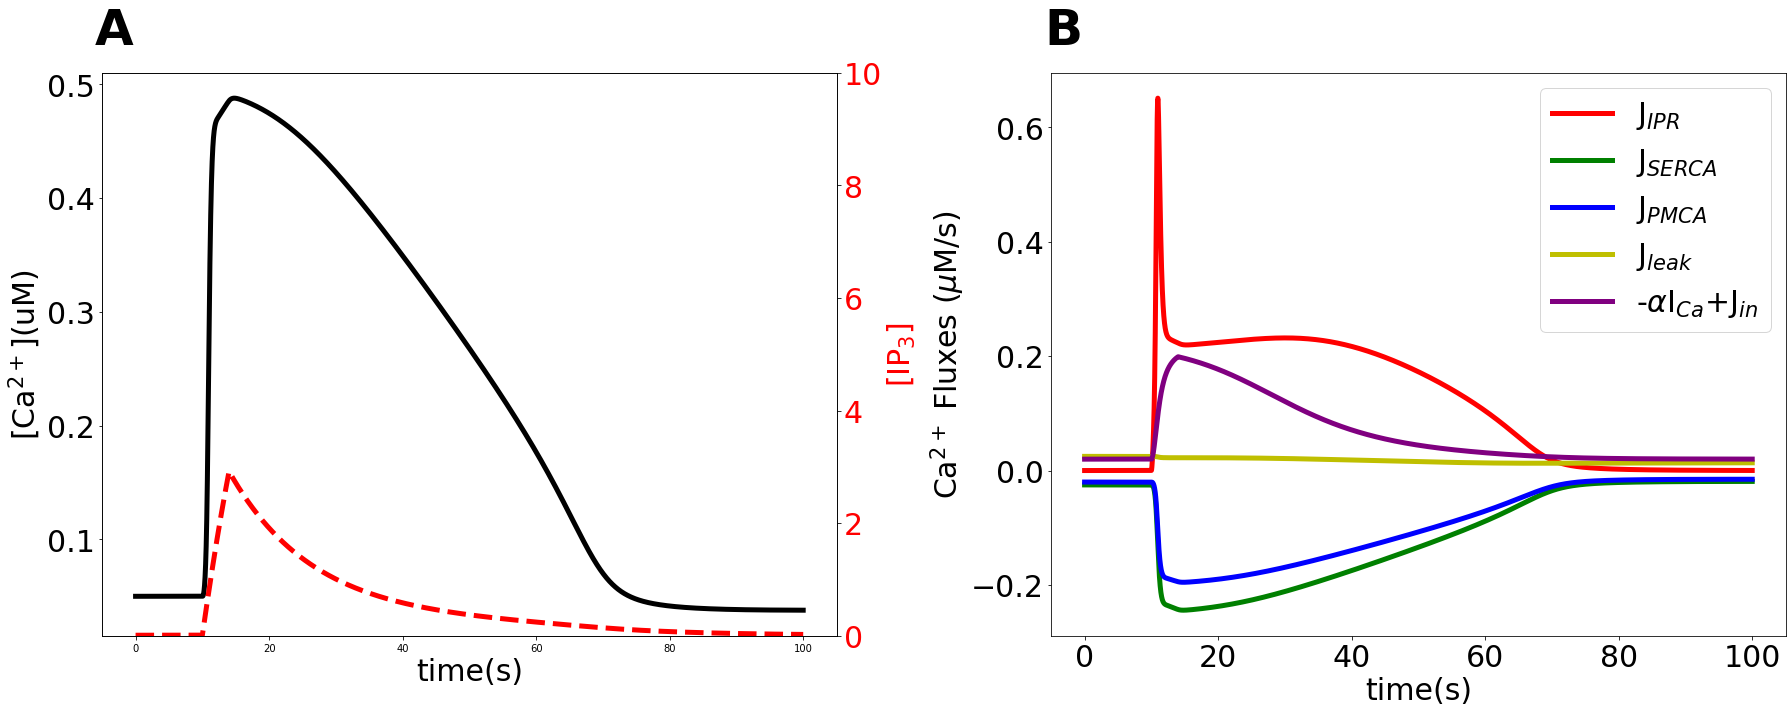

In [4]:
# Plot results of one slow transient
sol = model.run(stims_fast = [-100], 
                stims_slow = [10],
                T=100,
                dt=0.0002)
plot.plot_slow_transient(model, sol, 0, 100, full_cell=True, save_fig=True, save_path="./results/figures/slow-pathway.png")

In [5]:
# Plot multiple fast spikes
sol = model.run(stims_fast=[0, 4.4, 7.1, 9.3, 11.2, 13.2, 15.7, 18.4, 21.2, 24.7,
                            100, 105.2, 108.2, 110.6, 112.8, 115, 117.3, 119.4, 121.9, 125.1, 129.5, 134.3,
                            200, 205.7, 208.8, 211.6, 213.8, 216.1, 218.3, 221, 224.2, 229, 235.4], 
                stims_slow=[-100])

100%|██████████| 2500000/2500000 [02:15<00:00, 18476.95it/s]


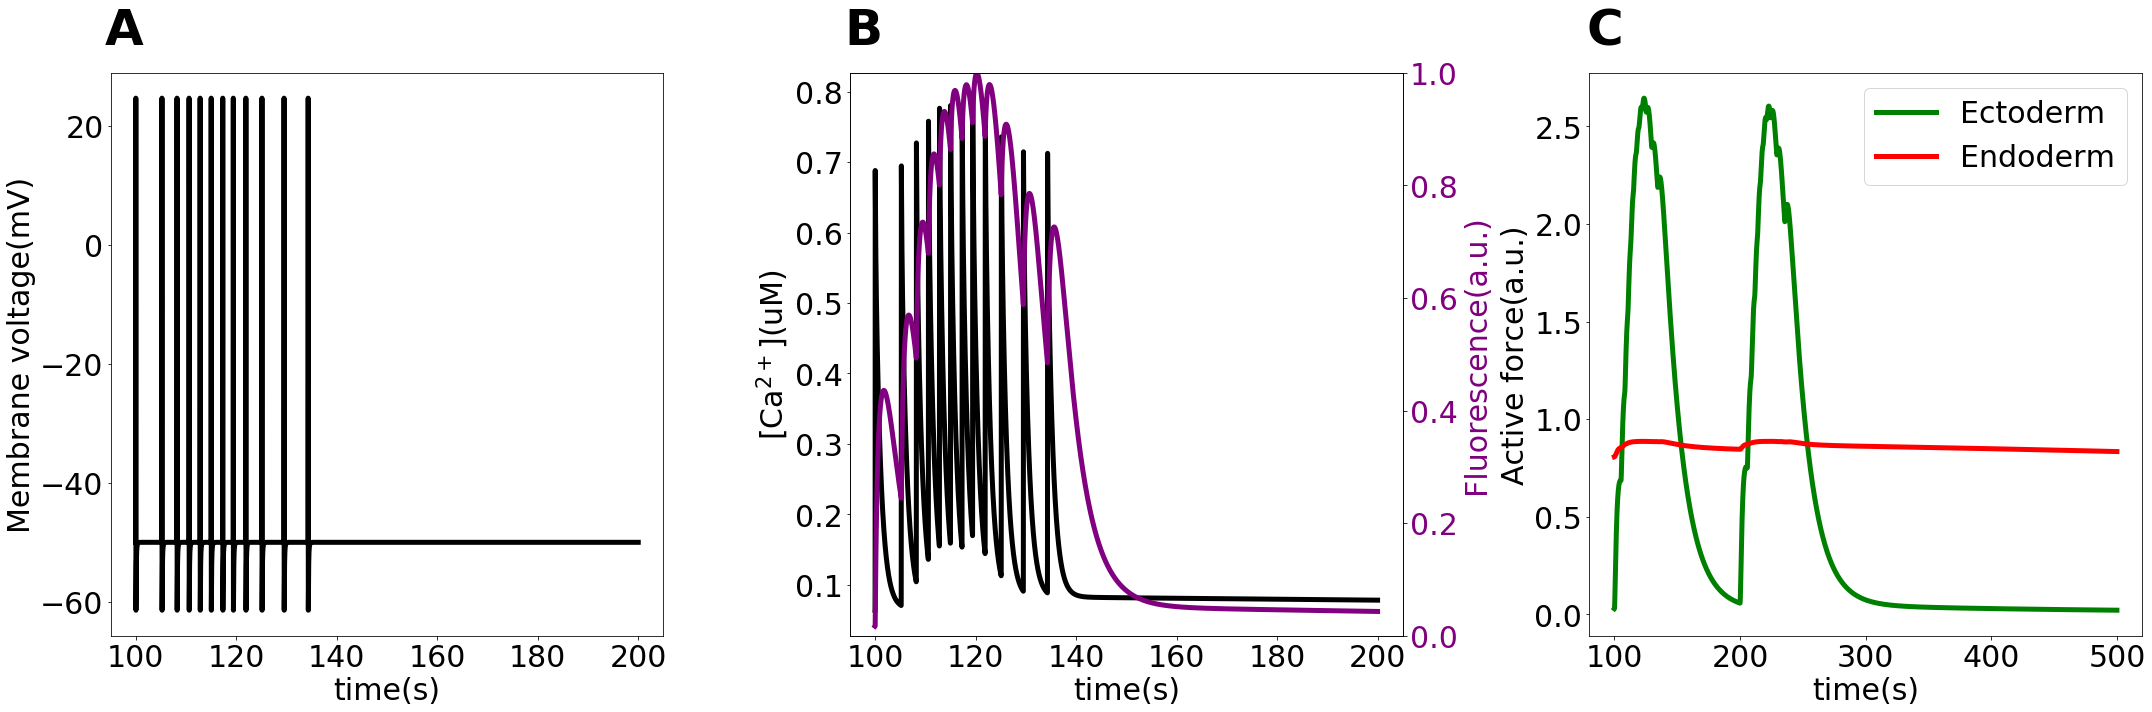

In [6]:
force_ecto = ForceEncoderEcto.encode(sol[:, 0], model.dt);
force_endo = ForceEncoderEndo.encode(sol[:, 0], model.dt);
plot.plot_multiple_spikes(model, sol, force_ecto, force_endo, 100, 200, 100, 500, save_fig=True, save_path="./results/figures/multiple-fast.png")

In [8]:
# Save the single-cell force data
force_ecto_intp = force_ecto[::50]
force_endo_intp = force_endo[::50]
time_intp = np.arange(0, 500, 0.01)

force_ecto_data = pd.DataFrame(np.array([time_intp, force_ecto_intp]).T)
force_endo_data = pd.DataFrame(np.array([time_intp, force_endo_intp]).T)

force_ecto_data.to_csv("./results/data/force/force_ecto_single.txt", index=False, header=False)
force_endo_data.to_csv("./results/data/force/force_endo_single.txt", index=False, header=False)

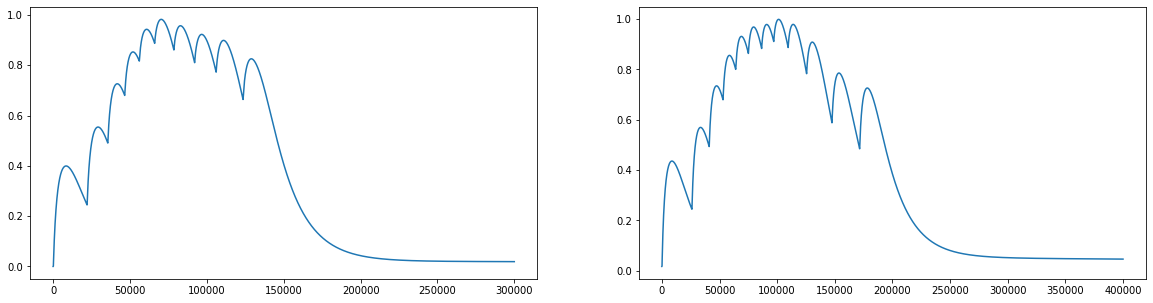

In [14]:
# Plot the encoded fluorescence of the two CBs
c = sol[:, 0]
v = sol[:, 4]
fluo_encoder = FluoEncoder(c, T=model.T, dt=model.dt)
fluo = fluo_encoder.step()
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot((fluo[0:300000]-min(fluo))/(max(fluo)-min(fluo)))
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot((fluo[500000:900000]-min(fluo))/(max(fluo)-min(fluo)))
plt.show()

## Multicellular Dynamics

In [57]:
# Run the model ()
# !bash manager.sh

In [149]:
FILENAME = "2020-04-19-20-49-10-037756"

# Load metadata
data = pd.read_csv("~/Documents/hydramuscle/hydramuscle/results/data/calcium/meta.txt", sep="\s+")
print(data.Metadata[data.Filename == FILENAME].values[0])

numx=200,numy=200,T=100,dt=0.0002,k_ipr=0.04,s0=100.0,d=0.002,v_delta=0.03


In [150]:
# Read the simulation results
calcium = pd.read_csv("./results/data/calcium/" + FILENAME + ".csv").values
calcium = calcium.reshape(len(calcium), 200, 200)

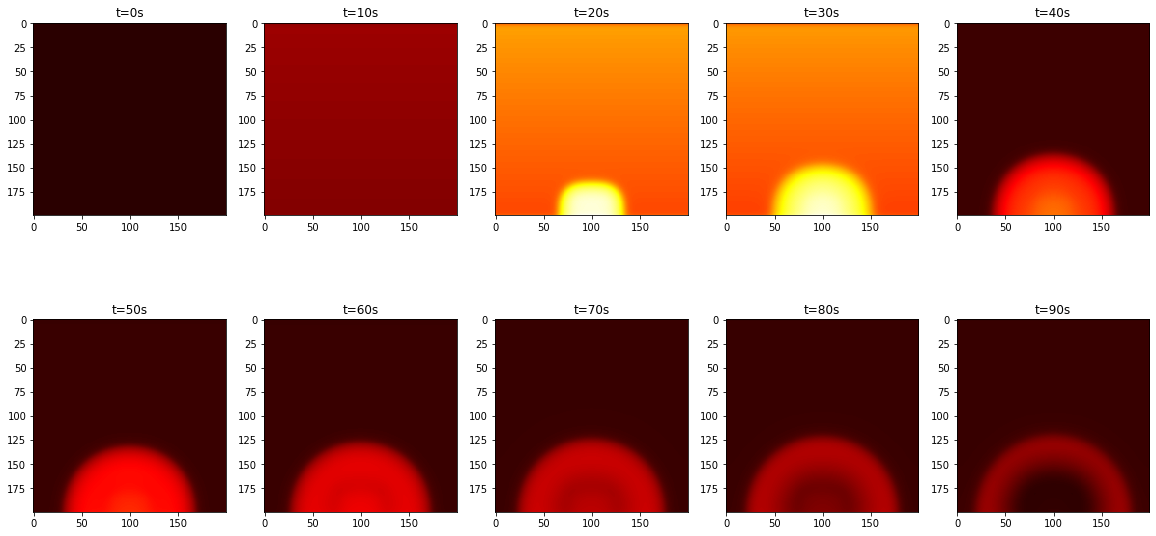

In [151]:
# Plot calcium patterns at specified times
plot.plot_frame_patterns(calcium, list(range(0, 100, 10)), vmin=0, vmax=1, dt=0.02)

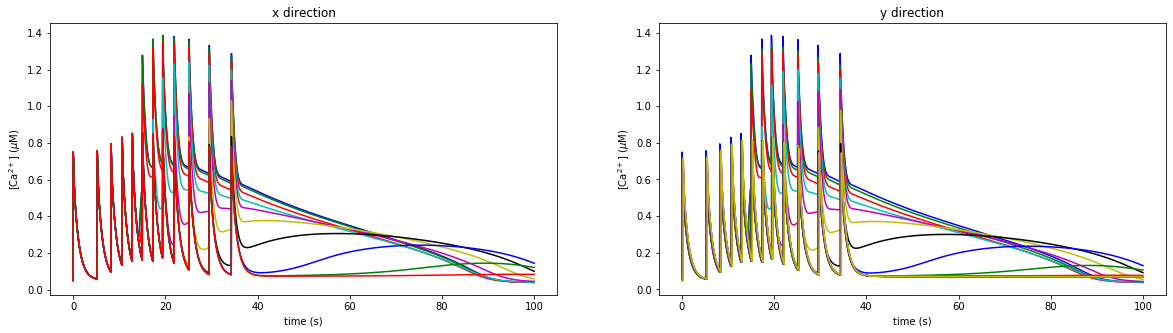

In [152]:
# Plot the calcium traces in different directions
plot.plot_1d_traces(calcium, 10, 0.02)

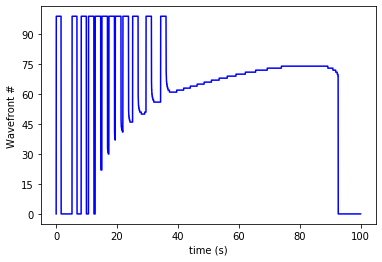

In [153]:
# Track the wavefront 
timeline = np.linspace(0, 100, int(100/0.02))
wavefront = helper.track_wavefront(calcium[:, 100:200, 0], 0.2)
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(timeline, wavefront)
ax.set_xlabel("time (s)")
ax.set_ylabel("Wavefront #")
plt.show()